<a href="https://colab.research.google.com/github/mohsenh17/jaxLearning/blob/main/parallelMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap

from jax import random
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Tuple, NamedTuple
import functools

In [2]:
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [28]:
class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray


lr = 0.008



def mlp_model_initialization(rng, layer_widths):
    params =[]
    weights_key, bias_key = jax.random.split(rng)

    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        weights_key, bias_key = jax.random.split(rng)
        weights = jax.random.normal(weights_key, (n_in, n_out))* jnp.sqrt(2 / n_in)
        bias = jax.random.normal(bias_key, (n_out,))
        params.append(Params(weights, bias))
    return params

#params = mlp_model_initialization(jax.random.PRNGKey(0), [1, 10, 1])

def mlp_forward(params, x):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.relu(jnp.dot(x, layer.weight)+layer.bias)

    return jnp.dot(x,last.weight)+last.bias

def mlp_loss_fn(params, x, y):
    return jnp.sqrt(jnp.mean((mlp_forward(params, x) - y) ** 2))  # RMSE loss

@functools.partial(jax.pmap, axis_name='batch') # to avoild later use of axis_name and pmap
def mlp_update(params, xs, ys):

    loss, grads = jax.value_and_grad(mlp_loss_fn)(params, xs, ys)

    grads = jax.lax.pmean(grads, axis_name='batch') # mean over batch dim

    loss = jax.lax.pmean(loss, axis_name='batch') # mean over bath im

    new_params = jax.tree.map(
        lambda param, g: param - g * lr, params, grads)

    return new_params, loss

####


def model_initialization(rng):
    weights_key, bias_key = jax.random.split(rng)
    weight = jax.random.normal(weights_key, ())
    bias = jax.random.normal(bias_key, ())
    return Params(weight, bias)


def forward(params, xs):
    return params.weight * xs + params.bias



def loss_fn(params, xs, ys):
    pred = forward(params, xs)
    return jnp.sqrt(jnp.mean((pred - ys) ** 2))  # RMSE


@functools.partial(jax.pmap, axis_name='batch') # to avoild later use of axis_name and pmap
def update(params, xs, ys):

    loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)

    grads = jax.lax.pmean(grads, axis_name='batch') # mean over batch dim

    loss = jax.lax.pmean(loss, axis_name='batch') # mean over bath im

    new_params = jax.tree.map(
        lambda param, g: param - g * lr, params, grads)

    return new_params, loss

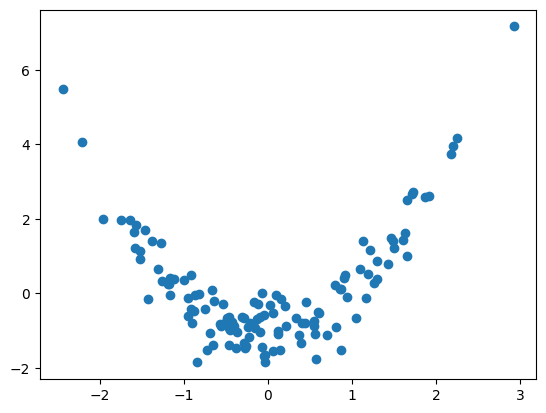

In [31]:
true_w, true_b = 2, -1
xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
ys = xs ** true_w + true_b + noise

plt.scatter(xs, ys)
plt.show()

In [32]:
params = model_initialization(jax.random.PRNGKey(0))

n_devices = jax.local_device_count()
replicated_params = jax.tree.map(lambda x: jnp.array([x] * n_devices), params)
print(replicated_params)

# Prepare the data
def reshape_for_pmap(data, n_devices):
    return data.reshape(n_devices, data.shape[0] // n_devices, *data.shape[1:])

x_parallel = reshape_for_pmap(xs, n_devices)
y_parallel = reshape_for_pmap(ys, n_devices)

print(x_parallel.shape, y_parallel.shape)

Params(weight=Array([0.14389051, 0.14389051, 0.14389051, 0.14389051, 0.14389051,
       0.14389051, 0.14389051, 0.14389051], dtype=float32), bias=Array([-1.2515285, -1.2515285, -1.2515285, -1.2515285, -1.2515285,
       -1.2515285, -1.2515285, -1.2515285], dtype=float32))
(8, 16, 1) (8, 16, 1)


In [33]:
def type_after_update(name, obj):
    print(f"after first `update()`, `{name}` is a {type(obj)}")


num_epochs = 1300
for epoch in range(num_epochs):

    # This is where the params and data gets communicated to devices
    replicated_params, loss = update(replicated_params, x_parallel, y_parallel)

    if epoch == 0:
        type_after_update('replicated_params.weight', replicated_params.weight)
        type_after_update('loss', loss)
        type_after_update('x_parallel', x_parallel)

    if epoch % 100 == 0:
        print(loss.shape)
        print(f"Step {epoch:3d}, loss: {loss[0]:.3f}")

params = jax.device_get(jax.tree.map(lambda x: x[0], replicated_params))

after first `update()`, `replicated_params.weight` is a <class 'jaxlib.xla_extension.ArrayImpl'>
after first `update()`, `loss` is a <class 'jaxlib.xla_extension.ArrayImpl'>
after first `update()`, `x_parallel` is a <class 'numpy.ndarray'>
(8,)
Step   0, loss: 1.988
(8,)
Step 100, loss: 1.684
(8,)
Step 200, loss: 1.533
(8,)
Step 300, loss: 1.475
(8,)
Step 400, loss: 1.455
(8,)
Step 500, loss: 1.449
(8,)
Step 600, loss: 1.447
(8,)
Step 700, loss: 1.447
(8,)
Step 800, loss: 1.446
(8,)
Step 900, loss: 1.446
(8,)
Step 1000, loss: 1.446
(8,)
Step 1100, loss: 1.446
(8,)
Step 1200, loss: 1.446


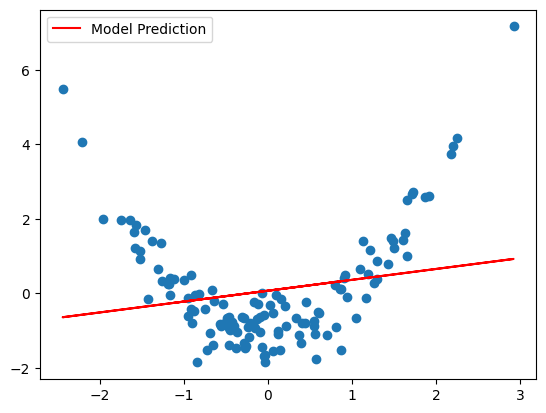

In [34]:
plt.scatter(xs, ys)
plt.plot(xs, forward(params, xs), c='red', label='Model Prediction')
plt.legend()
plt.show()

In [38]:
mlp_params = mlp_model_initialization(jax.random.PRNGKey(0),[1,32,128,32,1])

n_devices = jax.local_device_count()
replicated_params = jax.tree.map(lambda x: jnp.array([x] * n_devices), mlp_params)
print(replicated_params)

# Prepare the data
def reshape_for_pmap(data, n_devices):
    return data.reshape(n_devices, data.shape[0] // n_devices, *data.shape[1:])

x_parallel = reshape_for_pmap(xs, n_devices)
y_parallel = reshape_for_pmap(ys, n_devices)

print(x_parallel.shape, y_parallel.shape)

[Params(weight=Array([[[-1.1277484 ,  0.86224914, -2.4255078 , -0.9069135 ,
          0.29366967,  0.95682454, -2.5438051 ,  0.7452032 ,
          2.570459  ,  0.37780008,  1.8272204 ,  0.30370855,
         -0.15912034,  1.5658036 , -1.2532703 , -1.9556773 ,
          0.03399535, -0.41874346,  2.9444995 ,  2.0392923 ,
          1.4045656 , -0.43915305,  2.8945663 , -0.14934969,
          0.87989116,  1.331946  ,  2.4793692 , -1.0679257 ,
         -1.4209418 ,  0.25894004,  0.87623787,  1.0191528 ]],

       [[-1.1277484 ,  0.86224914, -2.4255078 , -0.9069135 ,
          0.29366967,  0.95682454, -2.5438051 ,  0.7452032 ,
          2.570459  ,  0.37780008,  1.8272204 ,  0.30370855,
         -0.15912034,  1.5658036 , -1.2532703 , -1.9556773 ,
          0.03399535, -0.41874346,  2.9444995 ,  2.0392923 ,
          1.4045656 , -0.43915305,  2.8945663 , -0.14934969,
          0.87989116,  1.331946  ,  2.4793692 , -1.0679257 ,
         -1.4209418 ,  0.25894004,  0.87623787,  1.0191528 ]],

   

In [39]:
def type_after_update(name, obj):
    print(f"after first `update()`, `{name}` is a {type(obj)}")


num_epochs = 1300
for epoch in range(num_epochs):

    # This is where the params and data gets communicated to devices
    replicated_params, loss = mlp_update(replicated_params, x_parallel, y_parallel)

    if epoch == 0:
        #type_after_update('replicated_params.weight', replicated_params.weight)
        type_after_update('loss', loss)
        type_after_update('x_parallel', x_parallel)

    if epoch % 100 == 0:
        print(loss.shape)
        print(f"Step {epoch:3d}, loss: {loss[0]:.3f}")

params = jax.device_get(jax.tree.map(lambda x: x[0], replicated_params))

after first `update()`, `loss` is a <class 'jaxlib.xla_extension.ArrayImpl'>
after first `update()`, `x_parallel` is a <class 'numpy.ndarray'>
(8,)
Step   0, loss: 1.119
(8,)
Step 100, loss: 0.641
(8,)
Step 200, loss: 0.559
(8,)
Step 300, loss: 0.529
(8,)
Step 400, loss: 0.507
(8,)
Step 500, loss: 0.501
(8,)
Step 600, loss: 0.502
(8,)
Step 700, loss: 0.498
(8,)
Step 800, loss: 0.491
(8,)
Step 900, loss: 0.492
(8,)
Step 1000, loss: 0.476
(8,)
Step 1100, loss: 0.484
(8,)
Step 1200, loss: 0.483


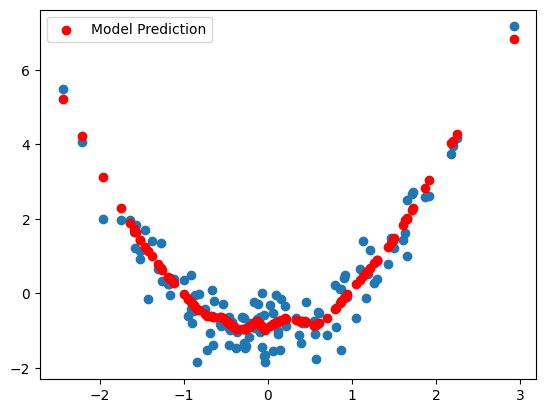

In [41]:
plt.scatter(xs, ys)
plt.scatter(xs, mlp_forward(params, xs), c='red', label='Model Prediction')
plt.legend()
plt.show()